### EPKM tables and scatters for CDS+3UTR for STAMP samples 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from collections import OrderedDict, defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [2]:
input_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data/final_analysis/01_SAILOR_bulk_rnaseq/outputs/combined_outputs_w_cov_info/'
ribo_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/'
output_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/cds_plus_3utr/'
out_fig_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/cds_plus_3utr/figures/'

### Relevant counts and length files

In [3]:
all_gene_counts = pd.read_csv(os.path.join(ribo_dir, 'counts.cds_and_3utr.txt'), index_col=0, sep='\t', comment='#').drop(['Chr', 'Start', 'End', 'Strand'],axis=1)

rename_dict = {}

for x in all_gene_counts.columns[1:]:
    rename_dict[x] = os.path.basename(x).split('_S')[0]

    
all_gene_counts = all_gene_counts.rename(columns=rename_dict)    
all_gene_counts.head()

,Length,ApoControl-0,ApoControl-1000,ApoControl-50,RBFOX2-0,RBFOX2-1000,RBFOX2-50,RPS2-0,RPS2-1000,RPS2-50,RPS3-0,RPS3-1000,Sample11,Sample12,Sample13,Sample14,Sample15,Sample16,Sample17,Sample18,Sample19,Sample1,Sample20,Sample21,Sample22,Sample23,Sample24,Sample25,Sample26,Sample27,Sample28,Sample29,Sample2,Sample30,Sample31,Sample32,Sample41,Sample42,Sample4,Sample5,Sample7,Sample8,Sample_10,Sample_33,Sample_34,Sample_35,Sample_36,Sample_37,Sample_38,Sample_39,Sample_3,Sample_40,Sample_6,Sample_9,TI_10,TI_11,TI_1,TI_2,TI_49,TI_4,TI_50,TI_52,TI_53,TI_55,TI_56,TI_58,TI_59,TI_5,TI_7,TI_8
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000186092,915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,2588,0,0,3,3,0,4,1,0,0,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,4,0,0,0,0,0,1,3,2,0,4,0,0,0,0,0,1,0,3,0
ENSG00000235249,973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000269831,129,0,2,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
all_gene_length = pd.DataFrame(all_gene_counts.Length)
all_gene_length.head()

,Length
Geneid,
ENSG00000186092,915
ENSG00000237683,2588
ENSG00000235249,973
ENSG00000185097,973
ENSG00000269831,129


In [5]:
all_gene_length = all_gene_length.rename(columns={'Length':'length'}) # this is just to clarify a naming inconsistency for a later function

### Relevant Expression files

In [6]:
stamp_rpkm = pd.read_csv(ribo_dir+'all_stamp_counts_rpkm.txt', sep='\t', index_col=0)
polysome_rpkm = pd.read_csv(ribo_dir+'Polysome_RPKM_Raw.txt', sep='\t')
polysome_x3_rpkm = pd.read_csv(ribo_dir+'fred_x3_polysome_RPKM.txt', sep='\t', index_col=0)
riboseq1_rpkm = pd.read_csv(ribo_dir+'riboseq_pc_rpkm.txt', sep='\t',index_col=0)
ribolace1_rpkm = pd.read_csv(ribo_dir+'ribolace_pc_rpkm.txt', sep='\t',index_col=0)
riboseq2_rpkm = pd.read_csv(ribo_dir+'GSE94460_RPKM.txt', sep='\t',index_col=0)

In [7]:
# piping in previously used functions for epkm calculation 
def read_and_process_edits_df(edits_file):
    
    """
    Reads in annotated files, gets rid of editing events with multiple annotations, 
    removes any editing events that fall into intergenic regions, and separates edit 
    and non-edit coverage across each site. Additionally, it abbreviates geneid by 
    removing the number after the decminal.
    """
    
    names = ['chr','start','end','score','edits','strand','geneid','gene_name','region','string'] 
    df = pd.read_csv(edits_file, sep='\t', names=names).drop('string',axis=1)
    
    df = df.loc[df.geneid.apply(lambda x: len(x.split(','))) == 1] # removing ambiguous editing events (more than one gene)
    df = df.loc[df.region != 'intergenic'] # removing intergenic events
    df['edit_count'] = df.edits.apply(lambda x: int(x.split(',')[0]))
    df['nonedit_count'] = df.edits.apply(lambda x: int(x.split(',')[1]))
    df.reset_index(inplace=True, drop=True)
    
    df['geneid'] = df.geneid.apply(lambda x: x.split('.')[0])
    
    return df

def filter_for_conf(edits_df, conf):
    # Pre-filter based on confidence score
    return edits_df.loc[edits_df.score >= conf]

def filter_cds_only(edits_df):
    # Filter for events that only fall into regions annotated as CDS
    return edits_df.loc[edits_df.region == 'CDS']

def filter_3utr_only(edits_df):
    # Filter for events that only fall into regions annotated as 3UTR
    return edits_df.loc[edits_df.region == '3utr']

def filter_exons(edits_df):
    # Filter for events that overlap with 5UTR/CDS/3UTR (should be all exons)
    return edits_df.loc[(edits_df.region == '5utr') | (edits_df.region == '3utr') | (edits_df.region == 'CDS')]

def filter_cds_and_3utr(edits_df):
    # Filter for events that overlap with 5UTR/CDS/3UTR (should be all exons)
    return edits_df.loc[(edits_df.region == '3utr') | (edits_df.region == 'CDS')]

def per_gene_ecounts(processed_edits_df):
    
    """
    Sums both edited coverage and non-edited coverage on a per gene basis. Ends up saving
    into a different dataframe separate from the original annotated bed file. 
    """
    
    edit_counts = processed_edits_df[['geneid', 'edit_count']].groupby('geneid').sum()
    no_edit_counts = processed_edits_df[['geneid', 'nonedit_count']].groupby('geneid').sum()
    
    df = pd.merge(edit_counts, no_edit_counts, how='outer', left_index=True, right_index=True)
    return df

def epkm(ecounts_df):
    
    """
    Calculation of EPKM, which is the following:
    
    (Coverage (counts) over edit site with 'T' reads per gene) / (((total read count mapping to region/exons)*(10**-6)) * ((length of mapped region)*(10**-3)))
    
    """
    
    ecounts_df['EPKM'] = ecounts_df['edit_count'] / ((ecounts_df['counts'].sum() / 10**6) * (ecounts_df['length']/1000))
    return ecounts_df

def edits_te(ecounts_df):
    
    """
    Calculation of TE metric, which is the following:
    
    (Coverage (counts) over edit site with 'T' reads per gene) / (((total read count mapping to EACH GENE)*(10**-3)) * ((length of mapped region)*(10**-3)))
    
    """
    
    ecounts_df['te'] = ecounts_df['edit_count'] / ((ecounts_df['counts']/1000)* (ecounts_df['length']/1000))
    return ecounts_df

def r2pearson(x, y):
    # Pearson correlation (R2) shortcut 
    return pearsonr(x, y)[0] ** 2

### Reading in all samples 

In [8]:
# Picking out relevant samples that I have count information for 
sample_prefixes = list(all_gene_counts.columns[1:])

annotated_samples = []

for sample in sample_prefixes:
    
    sample_path = glob.glob(os.path.join(input_dir, '{}*.out.sorted_a0_b0_e0.01.annotated'.format(sample)))
    
    for c in sample_path:
        annotated_samples.append(c)

In [9]:
# Putting all edits tables into one dictionary
sample_dict = defaultdict(lambda: 'None')

for a in annotated_samples:
    sample_name = os.path.basename(a).split('_S')[0]
    sample_dict[sample_name] = read_and_process_edits_df(a)

In [10]:
# Rolling all epkm results into one dictionary as well for easier iteration--CDS only
epkm_dict = defaultdict(lambda: 'None')

confs = [0]

for k,v in sample_dict.items():
    for conf in confs:
        # Reads in annotated bed files and returns dataframes with edits counts 
        filtered = filter_for_conf(filter_cds_and_3utr(v), conf)
        ecounts = per_gene_ecounts(filtered)
        
        # merge with relevant counts files from featurecounts mapping--fill expressed genes with no edits with 0s  
        ecounts = pd.merge(ecounts, all_gene_counts[k], how='outer', left_index=True, right_index=True).fillna(0) # CDS counts only 
        ecounts = ecounts.rename(columns={'{}'.format(k):'counts'}) # rename sample counts columns
        ecounts = pd.merge(ecounts, all_gene_length, how='outer', left_index=True, right_index=True).fillna(0) # CDS lengths only
        ecounts = ecounts.loc[ecounts.length > 0] # For some reason some genes with edits but no gene annotation (remove)
        ecounts = ecounts[ecounts['counts'] > 0] # this is an optional step if we want to filter out genes with no expression counts
        
        # addition of epkm values and addition of a pseudocount
        ecounts = epkm(ecounts)
        ecounts['EPKM+ps'] = ecounts['EPKM'] + 1
        
        # addition of TE values
        ecounts = edits_te(ecounts).fillna(0)
        name_string = k+'_conf{}'.format(str(conf))
        
        epkm_dict[name_string] = ecounts
        
        ecounts.to_csv(output_dir+'{}_epkm_table_cds_3utr_only.txt'.format(name_string), sep='\t')

### Riboseq comparison

In [11]:
riboseq2_samples = ['ApoControl-0_conf0', 'ApoControl-1000_conf0', 'ApoControl-50_conf0',
                   'RPS2-0_conf0', 'RPS2-1000_conf0', 'RPS2-50_conf0', 'RPS3-0_conf0', 'RPS3-1000_conf0']

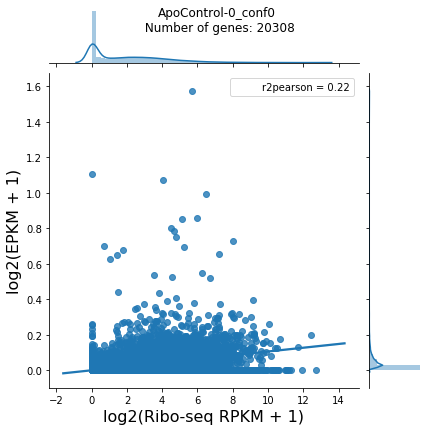

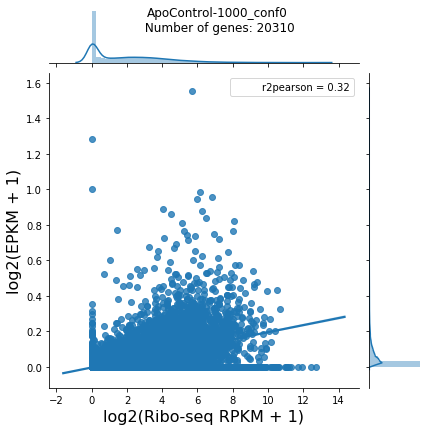

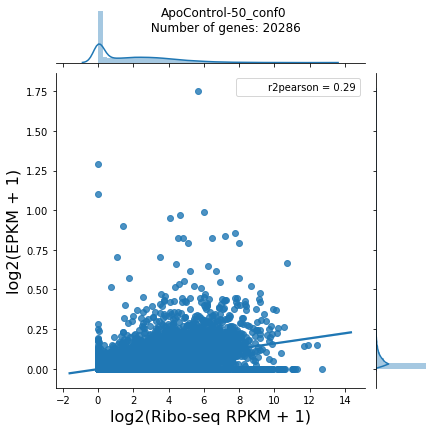

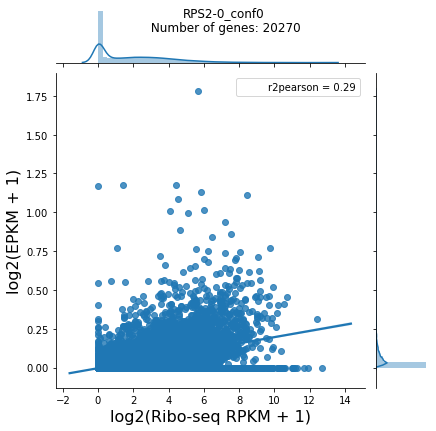

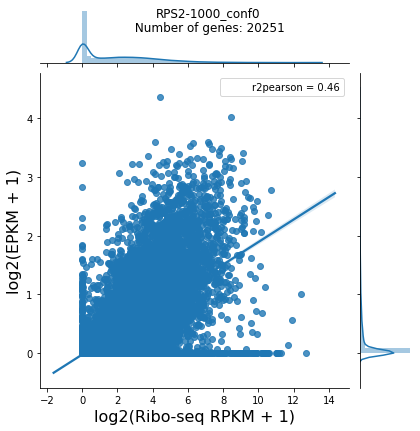

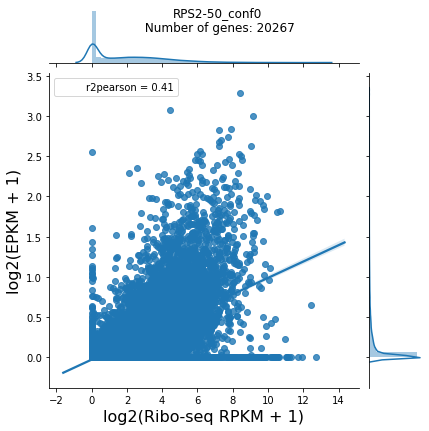

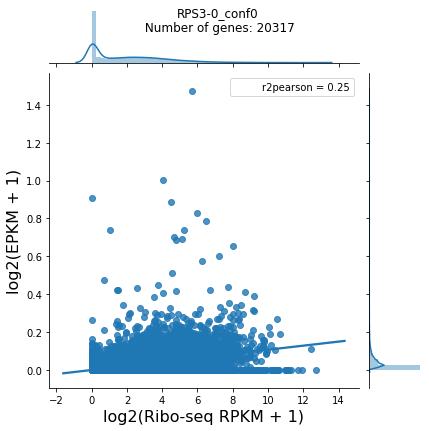

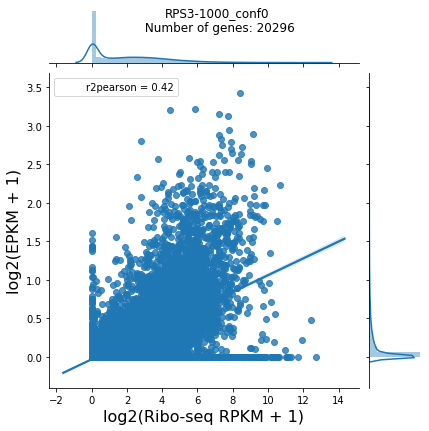

In [12]:
# Comparing to riboseq2 using all genes between two datasets
for sample in riboseq2_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_riboseq = pd.merge(edits_df, riboseq2_rpkm, how='outer', left_index=True, right_index=True).fillna(0)
    
    ecount_riboseq['l2epkm'] = np.log2(ecount_riboseq['EPKM']+1)
    ecount_riboseq['l2poly'] = np.log2(ecount_riboseq['mean_rpkm']+1)
    ecount_riboseq['l2_te'] = np.log2(ecount_riboseq['te']+1)
    
    genes = len(ecount_riboseq)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_riboseq,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Ribo-seq RPKM + 1)', 'log2(EPKM + 1)', fontsize=16)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_riboseq2_rpkm_all_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

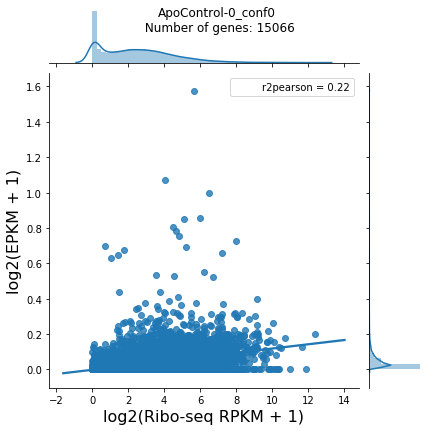

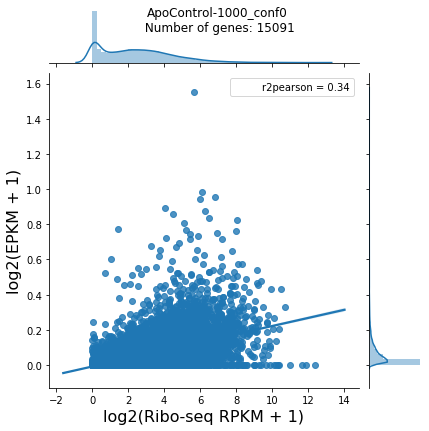

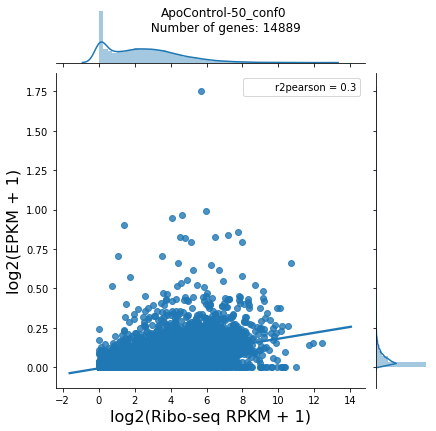

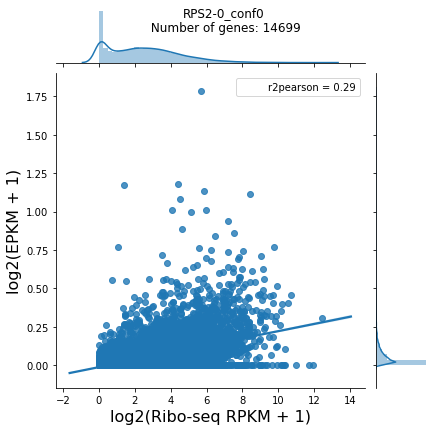

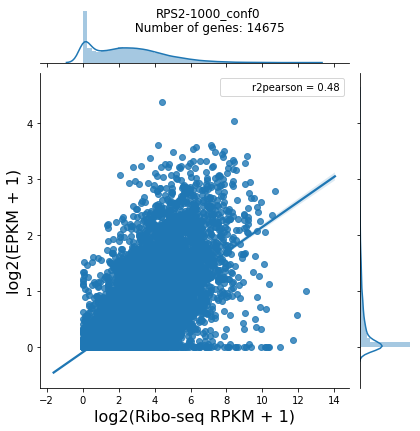

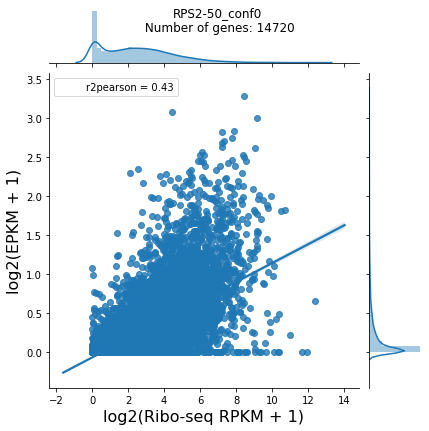

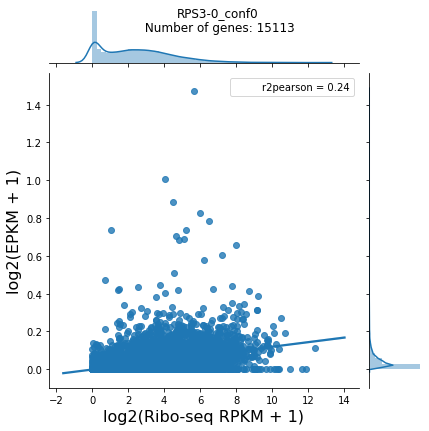

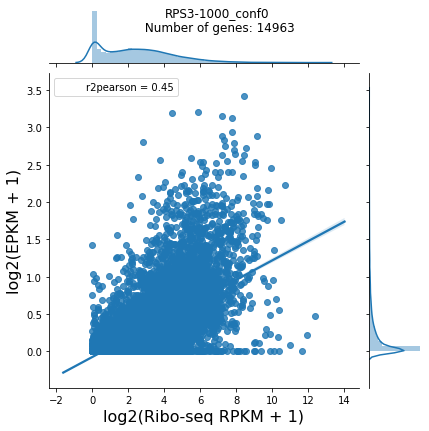

In [13]:
# Comparing to riboseq2 using only intersecting genes 
for sample in riboseq2_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_riboseq = pd.merge(edits_df, riboseq2_rpkm, how='inner', left_index=True, right_index=True)
    
    ecount_riboseq['l2epkm'] = np.log2(ecount_riboseq['EPKM']+1)
    ecount_riboseq['l2poly'] = np.log2(ecount_riboseq['mean_rpkm']+1)
    ecount_riboseq['l2_te'] = np.log2(ecount_riboseq['te']+1)
    
    genes = len(ecount_riboseq)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_riboseq,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Ribo-seq RPKM + 1)', 'log2(EPKM + 1)', fontsize=16)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_riboseq2_rpkm_intersecting_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

In [14]:
ribolace_samples = ['ApoControl-1000_conf0','RPS2-1000_conf0']

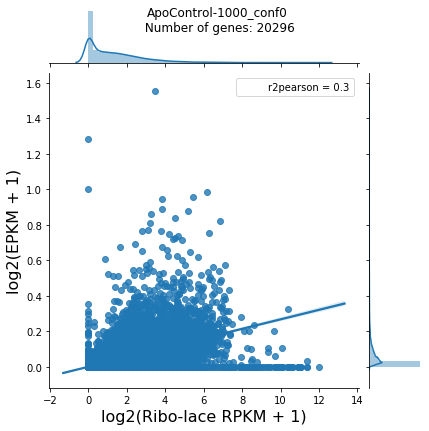

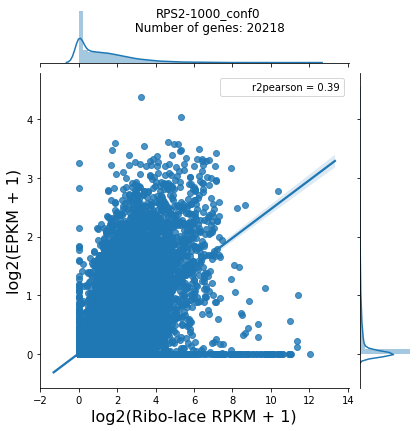

In [15]:
# Comparing to ribolace--all genes

for sample in ribolace_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_ribolace = pd.merge(edits_df, ribolace1_rpkm, how='outer', left_index=True, right_index=True).fillna(0)
    
    ecount_ribolace['l2epkm'] = np.log2(ecount_ribolace['EPKM']+1)
    ecount_ribolace['l2poly'] = np.log2(ecount_ribolace['avg_ribolace']+1)
    ecount_ribolace['l2_te'] = np.log2(ecount_ribolace['te']+1)
    
    genes = len(ecount_ribolace)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_ribolace,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Ribo-lace RPKM + 1)', 'log2(EPKM + 1)', fontsize=16)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_ribolace_rpkm_all_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

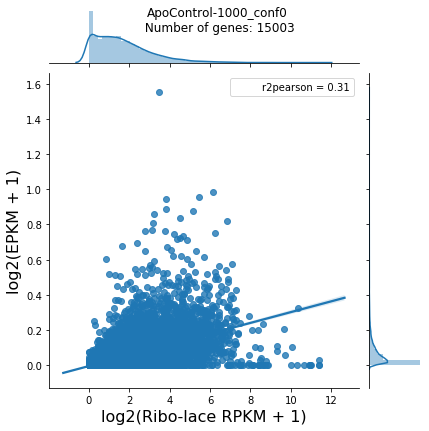

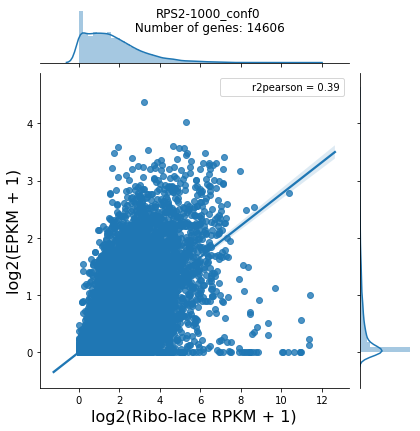

In [16]:
# Comparing to ribolace--intersecting genes

for sample in ribolace_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_ribolace = pd.merge(edits_df, ribolace1_rpkm, how='inner', left_index=True, right_index=True)
    
    ecount_ribolace['l2epkm'] = np.log2(ecount_ribolace['EPKM']+1)
    ecount_ribolace['l2poly'] = np.log2(ecount_ribolace['avg_ribolace']+1)
    ecount_ribolace['l2_te'] = np.log2(ecount_ribolace['te']+1)
    
    genes = len(ecount_ribolace)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_ribolace,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Ribo-lace RPKM + 1)', 'log2(EPKM + 1)', fontsize=16)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_ribolace_rpkm_intersecting_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

In [17]:
# Need to modify if we are going to log transform by adding ps to RPKM before normalization

polysome_x3_rpkm = polysome_x3_rpkm + 1
polysome_x3_rpkm['poly/input'] = polysome_x3_rpkm['x3_polysome'] / polysome_x3_rpkm['x3_input']
polysome_x3_rpkm.head()

,x3_input,x3_polysome,poly/input
Geneid,,,
ENSG00000262227,2.386483,1.000000,0.419027
ENSG00000273243,2.615120,1.000000,0.382392
ENSG00000254207,2.450542,1.215213,0.495896
ENSG00000230359,2.473046,1.542613,0.623770
ENSG00000105880,2.390836,1.430654,0.598391


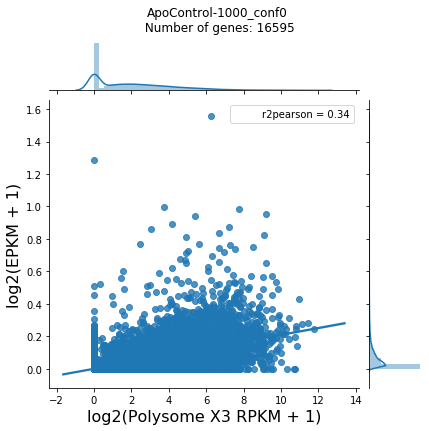

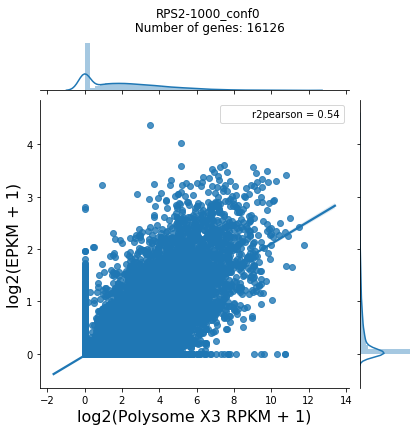

In [18]:
# Comparing to X3 polysome--all genes 

for sample in ribolace_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_polysome = pd.merge(edits_df, polysome_x3_rpkm, how='outer', left_index=True, right_index=True).fillna(1)
    
    ecount_polysome['l2epkm'] = np.log2(ecount_polysome['EPKM+ps'])
    ecount_polysome['l2poly'] = np.log2(ecount_polysome['x3_polysome'])
    ecount_polysome['l2_te'] = np.log2(ecount_polysome['te']+1)
    
    genes = len(ecount_polysome)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_polysome,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Polysome X3 RPKM + 1)', 'log2(EPKM + 1)', fontsize=16)
    plt.subplots_adjust(top=0.9)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_x3_polysome_nonnorm_rpkm_all_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

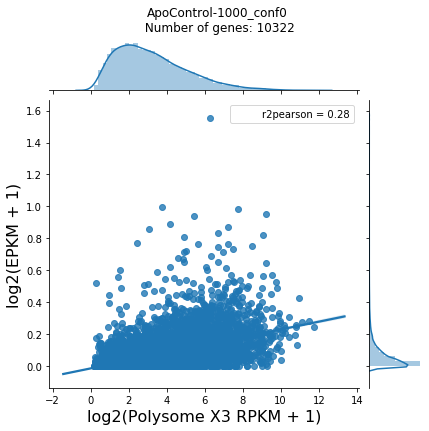

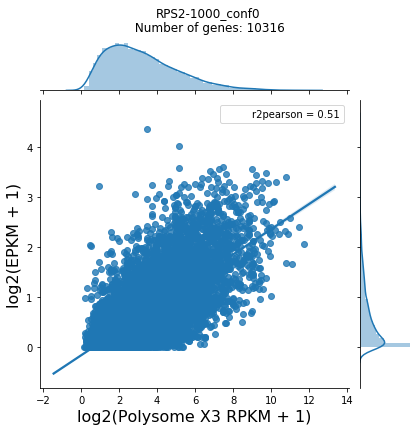

In [19]:
# Comparing to X3 polysome--intersecting genes

for sample in ribolace_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_polysome = pd.merge(edits_df, polysome_x3_rpkm, how='inner', left_index=True, right_index=True)
    
    ecount_polysome['l2epkm'] = np.log2(ecount_polysome['EPKM']+1)
    ecount_polysome['l2poly'] = np.log2(ecount_polysome['x3_polysome'])
    ecount_polysome['l2_te'] = np.log2(ecount_polysome['te']+1)
    
    genes = len(ecount_polysome)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_polysome,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Polysome X3 RPKM + 1)', 'log2(EPKM + 1)', fontsize=16)
    plt.subplots_adjust(top=0.9)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_x3_polysome_nonnorm_rpkm_intersecting_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

In [20]:
polysome_x3_rpkm.head()

,x3_input,x3_polysome,poly/input
Geneid,,,
ENSG00000262227,2.386483,1.000000,0.419027
ENSG00000273243,2.615120,1.000000,0.382392
ENSG00000254207,2.450542,1.215213,0.495896
ENSG00000230359,2.473046,1.542613,0.623770
ENSG00000105880,2.390836,1.430654,0.598391


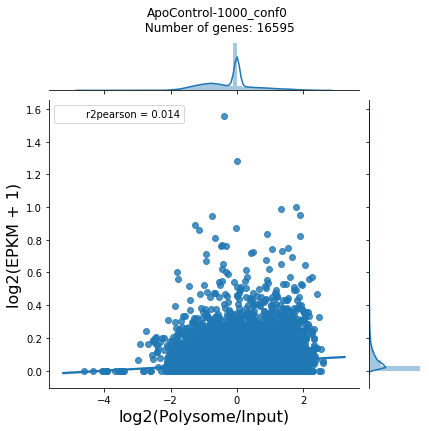

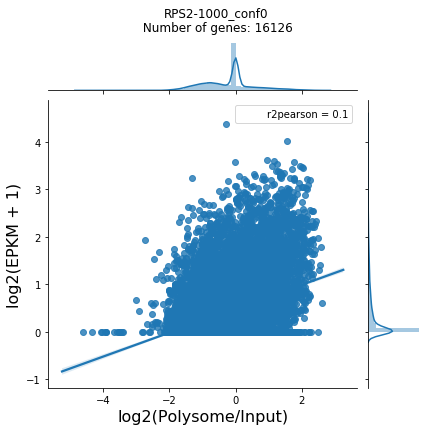

In [21]:
# Comparing to X3 polysome normalized--all genes
for sample in ribolace_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_polysome = pd.merge(edits_df, polysome_x3_rpkm, how='outer', left_index=True, right_index=True).fillna(1)
    
    ecount_polysome['l2epkm'] = np.log2(ecount_polysome['EPKM+ps'])
    ecount_polysome['l2poly'] = np.log2(ecount_polysome['poly/input'])
    ecount_polysome['l2_te'] = np.log2(ecount_polysome['te']+1)
    
    genes = len(ecount_polysome)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_polysome,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Polysome/Input)', 'log2(EPKM + 1)', fontsize=16)
    plt.subplots_adjust(top=0.9)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_x3_polysome_norm_rpkm_all_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

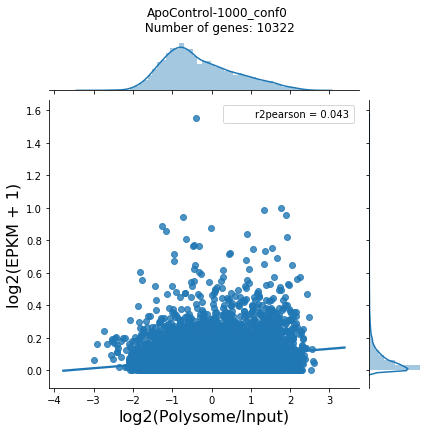

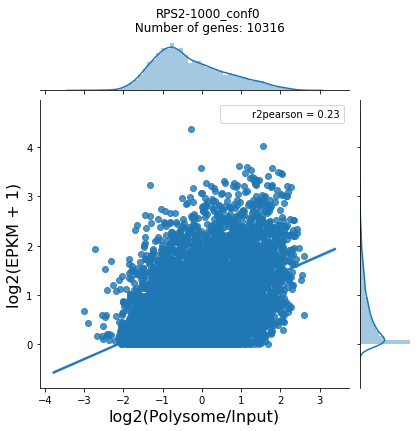

In [22]:
# Comparing to X3 polysome normalized--intersecting genes
for sample in ribolace_samples:
    
    edits_df = epkm_dict[sample]
    
    ecount_polysome = pd.merge(edits_df, polysome_x3_rpkm, how='inner', left_index=True, right_index=True)
    
    ecount_polysome['l2epkm'] = np.log2(ecount_polysome['EPKM']+1)
    ecount_polysome['l2poly'] = np.log2(ecount_polysome['poly/input'])
    ecount_polysome['l2_te'] = np.log2(ecount_polysome['te']+1)
    
    genes = len(ecount_polysome)
    
    f = sns.jointplot(
        x='l2poly',
        y='l2epkm',
        data=ecount_polysome,
        kind='reg',
        stat_func=r2pearson
    )
    
    f.fig.suptitle("{}\n Number of genes: {}".format(sample, genes))
    f.set_axis_labels('log2(Polysome/Input)', 'log2(EPKM + 1)', fontsize=16)
    plt.subplots_adjust(top=0.9)
    #f.savefig(out_fig_dir+'{}_cds_3utr_epkm_vs_x3_polysome_norm_rpkm_intersecting_genes.pdf'.format(sample), bbox_inches='tight', dpi=300)

## Cross-replicate comparisons

In [34]:
sample_ids = pd.read_csv(ribo_dir+'lenti_sample_ids.csv')
sample_ids.head()

,Sample,ID
0,Sample1,Apo_0_0_1
1,Sample2,Apo_0_0_2
2,Sample5,Apo_1000_24_1
3,Sample_6,Apo_1000_24_2
4,Sample_9,Apo_1000_48_1


In [35]:
samples_short = []

for s in sample_ids['ID']:
    id_info = s.split('_')[0:3]
    id_string = id_info[0] + '_' + id_info[1] + '_' + id_info[2] + 'hr'
    samples_short.append(id_string)
    
sample_ids['type'] = samples_short

In [44]:
sample_ids.columns

Index(['Sample', 'ID', 'type'], dtype='object')

In [45]:
replicate_dict = defaultdict(list)

for i in sample_ids.index:
    replicate_dict[sample_ids['type'][i]].append(sample_ids['Sample'][i])

In [46]:
replicate_dict

defaultdict(list,
            {'Apo_0_0hr': ['Sample1', 'Sample2'],
             'Apo_1000_24hr': ['Sample5', 'Sample_6'],
             'Apo_1000_48hr': ['Sample_9', 'Sample_10'],
             'Apo_1000_72hr': ['Sample13', 'Sample14'],
             'Apo_50_24hr': ['Sample_3', 'Sample4'],
             'Apo_50_48hr': ['Sample7', 'Sample8'],
             'Apo_50_72hr': ['Sample11', 'Sample12'],
             'RBFOX2_0_0hr': ['Sample15', 'Sample16'],
             'RBFOX2_1000_24hr': ['Sample19', 'Sample20'],
             'RBFOX2_1000_48hr': ['Sample23', 'Sample24'],
             'RBFOX2_1000_72hr': ['Sample27', 'Sample28'],
             'RBFOX2_50_24hr': ['Sample17', 'Sample18'],
             'RBFOX2_50_48hr': ['Sample21', 'Sample22'],
             'RBFOX2_50_72hr': ['Sample25', 'Sample26'],
             'RPS2_0_0hr': ['Sample29', 'Sample30'],
             'RPS2_1000_24hr': ['Sample_33', 'Sample_34'],
             'RPS2_1000_48hr': ['Sample_37', 'Sample_38'],
             'RPS2_1000_72hr': 

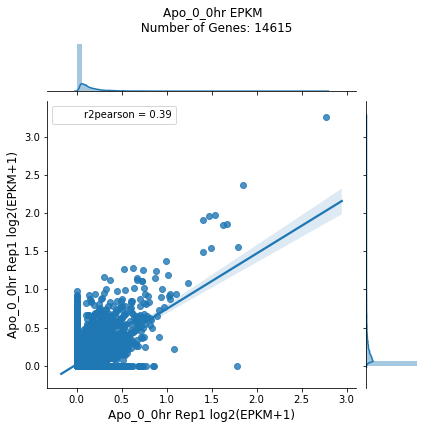

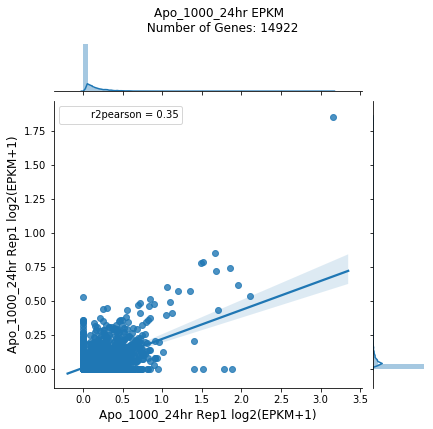

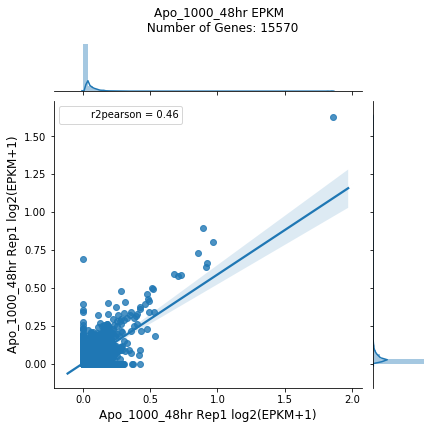

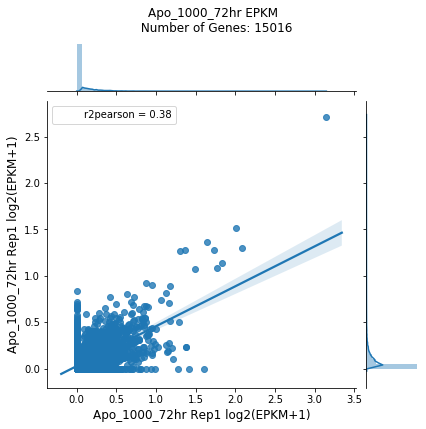

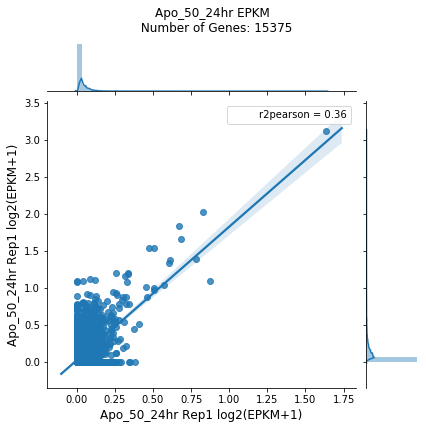

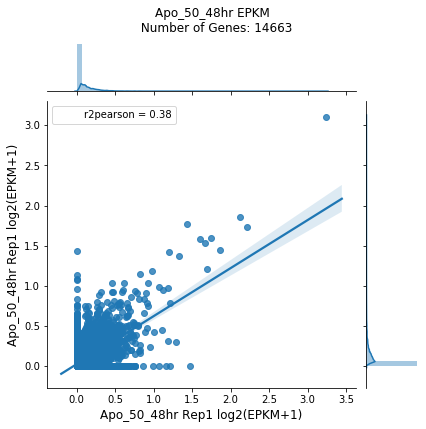

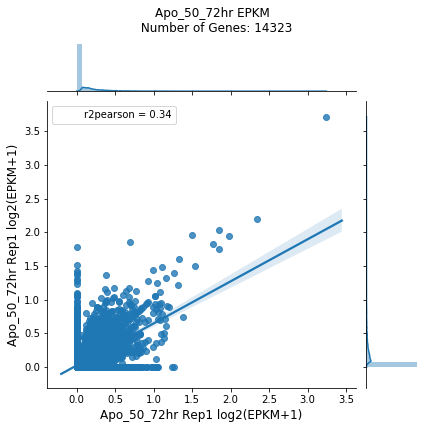

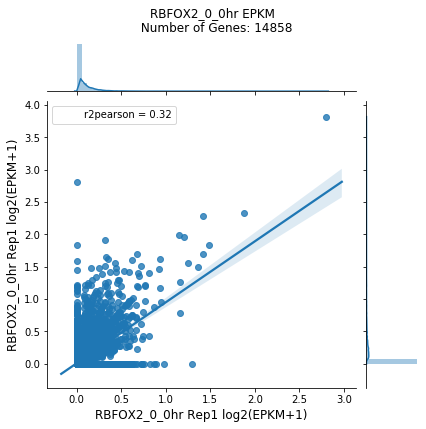

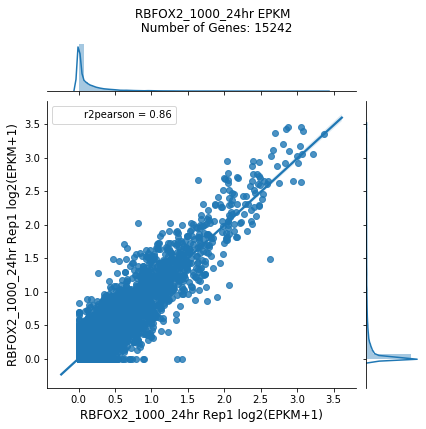

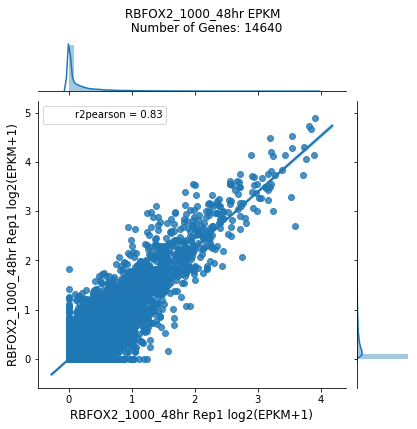

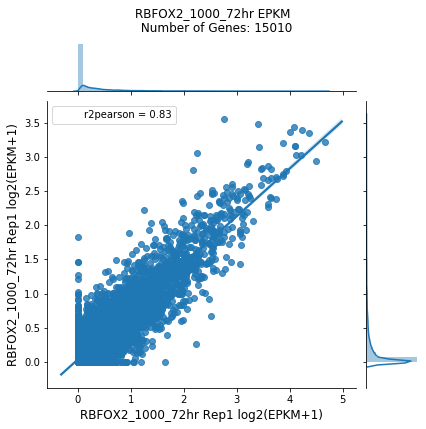

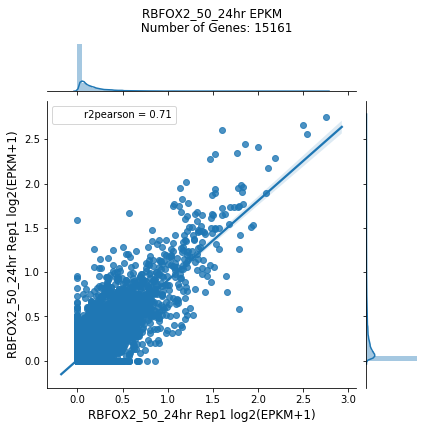

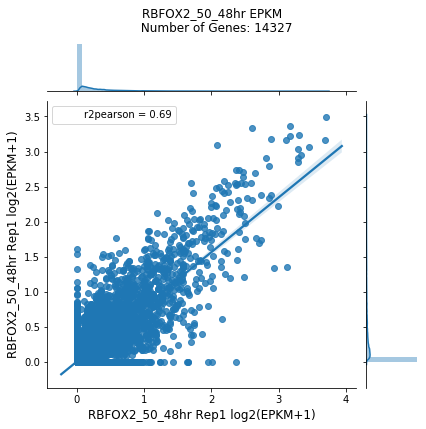

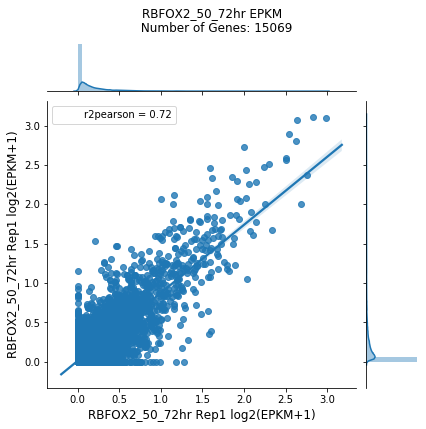

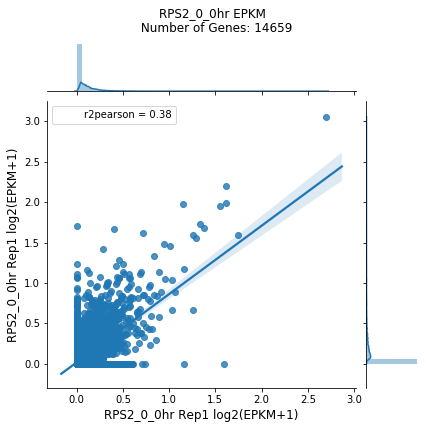

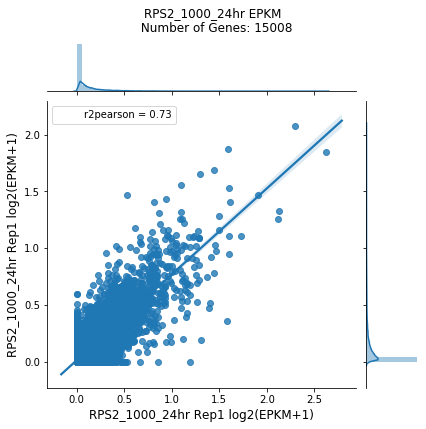

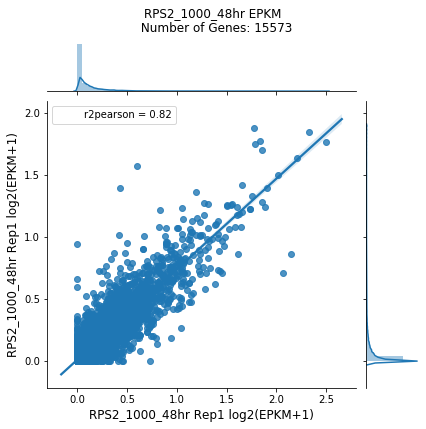

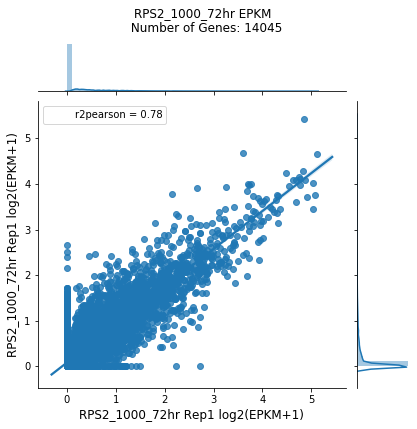

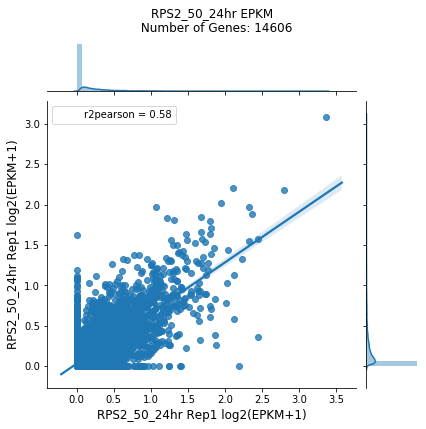

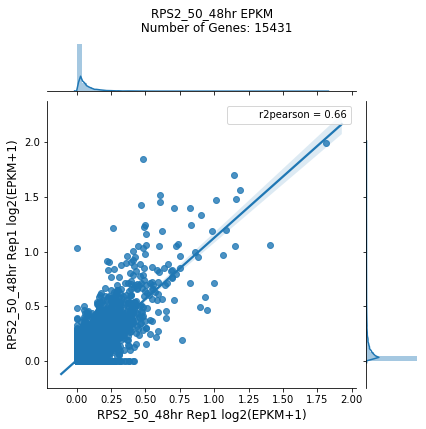

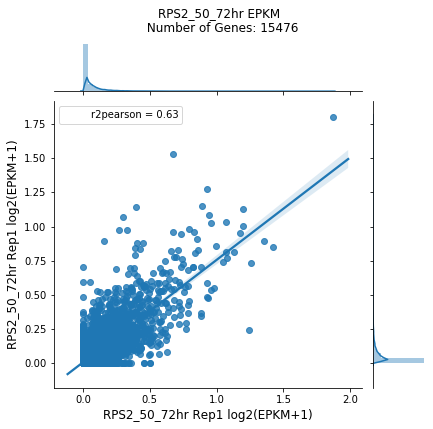

In [77]:
for k,v in replicate_dict.items():
    
    rep1 = epkm_dict[v[0]+'_conf0']['EPKM']
    rep2 = epkm_dict[v[1]+'_conf0']['EPKM']
    
    epkm_both = pd.merge(rep1, rep2, how='outer', left_index=True, right_index=True).fillna(0)
    
    genes = len(epkm_both)
    
    f = sns.jointplot(data=np.log2(epkm_both+1),
                  x='EPKM_x',
                  y='EPKM_y',
                 kind='reg',
                 stat_func=r2pearson)
    
    f.fig.suptitle('{} EPKM \n Number of Genes: {}'.format(k, str(genes)))
    f.set_axis_labels('{} Rep1 log2(EPKM+1)'.format(k), '{} Rep1 log2(EPKM+1)'.format(k), fontsize=12)
    plt.subplots_adjust(top=0.9)
    f.savefig(out_fig_dir+'{}_cds_3utr_epkm_replicates.pdf'.format(k), bbox_inches='tight', dpi=300)